### Preparation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
"""
!unzip '/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data.zip' -d '/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data'
"""

Archive:  /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data.zip
  inflating: /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_label.csv  
  inflating: /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/__MACOSX/Master project data/._data_label.csv  
replace /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_org_image/GfIraxmb.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_org_image/GfIraxmb.png  
  inflating: /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/__MACOSX/Master project data/data_org_image/._GfIraxmb.png  
replace /content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_org_image/P9giY4n0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a

In [2]:
import numpy as np
from collections import Counter

In [3]:
!pip install torchtoolbox

     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 3.3 MB 40.0 MB/s 
     |████████████████████████████████| 3.3 MB 51.7 MB/s 
     |████████████████████████████████| 895 kB 69.1 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
     |████████████████████████████████| 61 kB 440 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
! pip install -U albumentations

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 2.6 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
import albumentations as album
from albumentations.pytorch import ToTensorV2
import os
import pandas as pd
from PIL import Image
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchtoolbox.transform import Cutout
from torch.utils.data import DataLoader

In [6]:
! pip install scikit-image

### Classifier Testing

In [ ]:
def default_loader(path):
    return Image.open(path).convert('RGB')

def change_2848_loader(path):
    img = Image.open(path).convert('RGB')
    
    if img.size[0] < 2800:
        return img
    else:
        #print(img.size)###test
        img_pad = np.zeros((img.size[1] + 400, img.size[0], 3), dtype=np.uint8) ###800
        img_pad[400:400+2848, 160:] = np.asanyarray(img)[:, :-160]
        img = Image.fromarray(img_pad)
        return img

class DatasetFromCSV(Dataset):
    def __init__(self, image_root, csv_path, transforms=None, loader=default_loader):###change_2848_loader
        
        self.image_root = image_root
        
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 1])
        
        # process image name
        imgs = []
        files_names = np.array(self.data.iloc[:, 0])
        for img in files_names:
            imgs.append(os.path.join(self.image_root, str(img)))
        
        self.images = imgs
        self.transforms = transforms
        self.loader = loader
 
    def __getitem__(self, index):

        label = self.labels[index]
        img = self.images[index]
        img = self.loader(img)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, label
    
    def __len__(self):
        return len(self.data.index)

class MyDataset(Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip('\n')
            words = line.split()
            imgs.append((words[0],int(words[1])))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_mean = torch.tensor([0.7750, 0.5888, 0.7629])
data_std = torch.tensor([0.2129, 0.2971, 0.1774])
IMAGE_SIZE = 400
album_compose = album.Compose([
    album.Resize(IMAGE_SIZE, IMAGE_SIZE),                                          # Resize to IMAGE_SIZE x IMAGE_SIZE
    album.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0], max_pixel_value=255.0), # Rescale values from [0,255] to [0,1]
    album.Normalize(mean=data_mean, std=data_std, max_pixel_value=1.0),            # Rescale values according to above
    ToTensorV2(),
])

In [ ]:
test_dataset = DatasetFromCSV("/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_org_image/", "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_labels_test.csv", transforms=album_compose)

In [ ]:
from shutil import copy

In [ ]:
for i in range(len(test_dataset)):    
    img_tmp = test_dataset.images[i]
    labels_tmp = test_dataset.labels[i]
    #print(img_tmp, labels_tmp)
    copy(img_tmp, "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/test_image/")

In [ ]:
copy("/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_org_image/NIoh0vkL.png", "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/test_image/")

'/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/test_image/NIoh0vkL.png'

In [ ]:
!python '/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/predict_classification.py' 

Namespace(image_size=400, model='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/checkpoints/new/best.pt', source='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/test_image/')
Load Model Done!!!
65cQfRu2.png -> out: tensor([[-10.8355,  -4.2460,   6.0265]])
65cQfRu2.png -> preds: tensor([[4.7521e-08, 3.4567e-05, 9.9997e-01]])
65cQfRu2.png -> index: tensor([2])-> index.item=2
65cQfRu2.png -> prod: tensor([1.0000])




WJxem0Gd.png -> out: tensor([[ 8.0082, -1.3182, -2.1767]])
WJxem0Gd.png -> preds: tensor([[9.9987e-01, 8.9032e-05, 3.7728e-05]])
WJxem0Gd.png -> index: tensor([0])-> index.item=0
WJxem0Gd.png -> prod: tensor([0.9999])




RaxA2CwW.png -> out: tensor([[ 7.4581, -1.0670, -2.1258]])
RaxA2CwW.png -> preds: tensor([[9.9973e-01, 1.9837e-04, 6.8805e-05]])
RaxA2CwW.png -> index: tensor([0])-> index.item=0
RaxA2CwW.png -> prod: tensor([0.9997])




8dbAnUWh.png -> out: tensor([[-12.7687,  -8.7220,  10.0566]])
8dbAnUW

### Detection Set Partition

In [ ]:
'''
manually add one row to data_labels_test.csv, save as data_labels_test_1.csv
'''

In [ ]:
def partition_data(file='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/data_labels_test_1.csv', ratios=[0.80, 0.20], out_path='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/', uniform=False):
    """
    Partition data into training, validation and test data. Saves partitioned data
    to three .csv files.
    """

    # Define ratios for traning, validation and test
    ratio_train = ratios[0]
    ratio_test = ratios[1]

    # Import data
    data = np.genfromtxt(file, skip_header=1, dtype='str', delimiter=',')

    # Divide by image and label
    imgs = data[:,0]
    lbls = data[:,1]

    idxs_shuffle = np.random.permutation(len(lbls))
    imgs = imgs[idxs_shuffle]
    lbls = lbls[idxs_shuffle]

    # Print info
    print('NUMBER OF SAMPLES')
    samples_per_class(lbls)
    print('')

    # If uniformly many classes (do not use all data however)
    if uniform:
        # Find indices of each class
        idxs0 = np.where(lbls=='0')
        idxs1 = np.where(lbls=='1')
        idxs2 = np.where(lbls=='2')

        # Find number of samples for each class
        N0 = len(idxs0[0])
        N1 = len(idxs1[0])
        N2 = len(idxs2[0])
        N = min(N0, N1, N2)

        # Divide data by classes
        imgs0 = imgs[idxs0]
        lbls0 = lbls[idxs0]
        imgs1 = imgs[idxs1]
        lbls1 = lbls[idxs1]
        imgs2 = imgs[idxs2]
        lbls2 = lbls[idxs2]

        # Shuffle order
        idxs_shuffle0 = np.random.permutation(N0)
        idxs_shuffle1 = np.random.permutation(N1)
        idxs_shuffle2 = np.random.permutation(N2)
        imgs0 = imgs0[idxs_shuffle0]
        lbls0 = lbls0[idxs_shuffle0]
        imgs1 = imgs1[idxs_shuffle1]
        lbls1 = lbls1[idxs_shuffle1]
        imgs2 = imgs2[idxs_shuffle2]
        lbls2 = lbls2[idxs_shuffle2]

        # Take samples from each class
        imgs = []
        lbls = []
        for n in range(N):
            imgs.append(imgs0[n])
            lbls.append(lbls0[n])
            imgs.append(imgs1[n])
            lbls.append(lbls1[n])
            imgs.append(imgs2[n])
            lbls.append(lbls2[n])

    # Divide into training, validation and test data sets
    idxs_train = int(ratio_train*len(imgs))
    idxs_test = int((ratio_train+ratio_test)*len(imgs))
    imgs_train = imgs[0:idxs_train]
    imgs_test = imgs[idxs_train:]
    lbls_train = lbls[0:idxs_train]
    lbls_test = lbls[idxs_train:]

    # Save to files
    np.savetxt(out_path+'data_labels_test_attack_train.csv', np.vstack((imgs_train, lbls_train)).T, delimiter=',', fmt='%s')
    np.savetxt(out_path+'data_labels_test_attack_test.csv', np.vstack((imgs_test, lbls_test)).T, delimiter=',', fmt='%s')

    # Print information
    print('PARTITIONED DATA')
    print('  Training:    ' + str(int(100*ratios[0]))+'%, ' + str(len(lbls_train)) + ' samples')
    samples_per_class(lbls_train)
    print('')
    print('  Testing:     ' + str(int(100*ratios[1]))+'%, ' + str(len(lbls_test)) + ' samples')
    samples_per_class(lbls_test)
    print('')
    print('  Total:       ' + str(len(lbls_train)+len(lbls_test)))


def samples_per_class(lbls):
    counter = Counter(lbls)
    keys = counter.keys()
    values = counter.values()
    pairs = sorted(zip(keys, values))
    sum = 0
    output_format = '    Class {:<1}: {:>5}   {:>3}%'
    for pair in pairs:
        sum += pair[1]
    for pair in pairs:
        print(output_format.format(pair[0], pair[1], int(100*pair[1]/sum)))
    print('    Total:   {:>5}'.format(sum))

In [ ]:
partition_data()

NUMBER OF SAMPLES
    Class 0:    89    33%
    Class 1:    62    23%
    Class 2:   115    43%
    Total:     266

PARTITIONED DATA
  Training:    80%, 212 samples
    Class 0:    72    33%
    Class 1:    44    20%
    Class 2:    96    45%
    Total:     212

  Testing:     20%, 54 samples
    Class 0:    17    31%
    Class 1:    18    33%
    Class 2:    19    35%
    Total:      54

  Total:       266


### Attack Testesting

In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/deepfool.py" 

restrict_iter : False
restrict_ssim : True
###
0
original label:  2
new label:  1
ssim:  0.9983678967473878
loop num:  9
###
1
original label:  2
new label:  1
ssim:  0.9986834335785607
loop num:  8
###
2
original label:  0
new label:  0
ssim:  1
loop num:  0
###
3
original label:  0
new label:  0
ssim:  1
loop num:  0
###
4
original label:  2
new label:  2
ssim:  0.9966671914058937
loop num:  2
###
5
original label:  0
new label:  0
ssim:  1
loop num:  0
###
6
original label:  0
new label:  0
ssim:  1
loop num:  0
###
7
original label:  2
new label:  1
ssim:  0.9997487656092147
loop num:  1
###
8
original label:  2
new label:  1
ssim:  0.9996775344003815
loop num:  4
###
9
original label:  2
new label:  1
ssim:  0.9981007094084813
loop num:  8
###
10
original label:  2
new label:  1
ssim:  0.9991162584686618
loop num:  6
###
11
original label:  0
new label:  0
ssim:  1
loop num:  0
###
12
original label:  1
new label:  2
ssim:  0.9965770217988029
loop num:  4
###
13
original label:  2

In [ ]:
from shutil import copy
for i in range(266):    
    img_tmp = "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/" + "ori_" + str(i) + ".png"
    copy(img_tmp, "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case1/")
for i in range(266):    
    img_tmp = "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/" + "pert_" + str(i) + ".png"
    copy(img_tmp, "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case1/")    

In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/predict_classification.py" \
    --source='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case1/' \
    --out="/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/train_label_by_model_case1.csv"

Namespace(image_size=400, model='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/checkpoints/new/best.pt', out='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/train_label_by_model_case1.csv', source='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case1/')
Load Model Done!!!
ori_0.png -> out: tensor([[-15.8068,  -4.2527,   7.4470]])
ori_0.png -> preds: tensor([[7.9620e-11, 8.2964e-06, 9.9999e-01]])
ori_0.png -> index: tensor([2])-> index.item=2
ori_0.png -> prod: tensor([1.0000])




ori_1.png -> out: tensor([[-6.6738, -4.5536,  4.9322]])
ori_1.png -> preds: tensor([[9.1102e-06, 7.5915e-05, 9.9992e-01]])
ori_1.png -> index: tensor([2])-> index.item=2
ori_1.png -> prod: tensor([0.9999])




ori_2.png -> out: tensor([[ 7.7997, -1.1599, -2.1901]])
ori_2.png -> preds: tensor([[9.9983e-01, 1.2848e-04, 4.5859e-05]])
ori_2.png -> index: tensor([0])-> index.item=0
ori_2.png -> prod: tensor([0.9

In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/deepfool.py" --restrict_iter=false --restrict_ssim=false

restrict_iter : False
restrict_ssim : False
###
0
original label:  2
new label:  1
ssim:  0.9983678967473878
loop num:  9
###
1
original label:  2
new label:  1
ssim:  0.9986834335785607
loop num:  8
###
2
original label:  0
new label:  2
ssim:  0.8913806401951767
loop num:  1
###
3
original label:  0
new label:  2
ssim:  0.9943465760731908
loop num:  3
###
4
original label:  2
new label:  0
ssim:  0.9926054116424133
loop num:  10
###
5
original label:  0
new label:  2
ssim:  0.916071036864439
loop num:  1
###
6
original label:  0
new label:  2
ssim:  0.872517052942161
loop num:  6
###
7
original label:  2
new label:  1
ssim:  0.9997487656092147
loop num:  1
###
8
original label:  2
new label:  1
ssim:  0.9996775344003815
loop num:  4
###
9
original label:  2
new label:  1
ssim:  0.9981007094084813
loop num:  8
###
10
original label:  2
new label:  1
ssim:  0.9991162584686618
loop num:  6
###
11
original label:  0
new label:  2
ssim:  0.9257246096587535
loop num:  1
###
12
original lab

In [ ]:
from shutil import copy
for i in range(266):    
    img_tmp = "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/" + "ori_" + str(i) + ".png"
    copy(img_tmp, "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case2/")
for i in range(266):    
    img_tmp = "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/" + "pert_" + str(i) + ".png"
    copy(img_tmp, "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case2/")    

In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/predict_classification.py" \
    --source='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case2/' \
    --out="/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/train_label_by_model_case2.csv"

Namespace(image_size=400, model='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/checkpoints/new/best.pt', out='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/train_label_by_model_case2.csv', source='/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/attacked_image_case2/')
Load Model Done!!!
ori_0.png -> out: tensor([[-15.8068,  -4.2527,   7.4470]])
ori_0.png -> preds: tensor([[7.9620e-11, 8.2964e-06, 9.9999e-01]])
ori_0.png -> index: tensor([2])-> index.item=2
ori_0.png -> prod: tensor([1.0000])




ori_1.png -> out: tensor([[-6.6738, -4.5536,  4.9322]])
ori_1.png -> preds: tensor([[9.1102e-06, 7.5915e-05, 9.9992e-01]])
ori_1.png -> index: tensor([2])-> index.item=2
ori_1.png -> prod: tensor([0.9999])




ori_2.png -> out: tensor([[ 7.7997, -1.1599, -2.1901]])
ori_2.png -> preds: tensor([[9.9983e-01, 1.2848e-04, 4.5859e-05]])
ori_2.png -> index: tensor([0])-> index.item=0
ori_2.png -> prod: tensor([0.9

### Detection

In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=true --bit=5 --median_smoothing=true --size=3 --lr=0.7

color_depth:  True
reduce to:  5  bits
median_smoothing:  True
filter size:  3 x 3
########## bit depth ##########
### learning threshold c ###
threshold:  1.4263126850128174
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  55
false positive ratio:  0.6875
###
total number of attacked images:  80
total number of detected adversarial samples:  56
detection ratio:  0.7
########## median smoothing ##########
### learning threshold m ###
threshold:  0.8874587
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  9
false positive ratio:  0.1125
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  61
detection ratio:  0.7625


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.58911794
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  11
false positive ratio:  0.1375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  68
detection ratio:  0.85


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=false --size=2 --joint=true --lr=0.7

color_depth:  False
median_smoothing:  False
########## joint detection ##########
### learning threshold c ###
threshold:  1.4263126850128174
### learning threshold m ###
threshold:  0.58911794
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  11
false positive ratio:  0.1375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  68
detection ratio:  0.85


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.0

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  1.862109
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  1
false positive ratio:  0.0125
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  7
detection ratio:  0.0875


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.01

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  1.796902
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  2
false positive ratio:  0.025
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  7
detection ratio:  0.0875


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.03

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  1.4809517
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  6
false positive ratio:  0.075
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  11
detection ratio:  0.1375


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.05

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  1.0541077
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  7
false positive ratio:  0.0875
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  27
detection ratio:  0.3375


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.06

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.9547022
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  8
false positive ratio:  0.1
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  49
detection ratio:  0.6125


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.07

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.91483
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  9
false positive ratio:  0.1125
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  55
detection ratio:  0.6875


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.1

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.58911794
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  11
false positive ratio:  0.1375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  68
detection ratio:  0.85


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.15

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.3240439
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  14
false positive ratio:  0.175
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  73
detection ratio:  0.9125


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.2

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.13655171
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  16
false positive ratio:  0.2
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  79
detection ratio:  0.9875


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.25

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.047016803
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  18
false positive ratio:  0.225
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  79
detection ratio:  0.9875


In [ ]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.3

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.0040997905
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  29
false positive ratio:  0.3625
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  80
detection ratio:  1.0


In [ ]:
import matplotlib.pyplot as plt
fpr = [0, 0.0125, 0.0125, 0.0875, 0.0875, 0.1000, 0.1000, 0.1150, 0.1150, 0.1375, 0.1375, 0.1750, 0.1750, 0.2000, 0.2000, 0.3625, 0.3625]
tpr = [0, 0.0000, 0.0875, 0.0875, 0.3375, 0.3375, 0.6125, 0.6125, 0.6875, 0.6875, 0.8500, 0.8500, 0.9125, 0.9125, 0.9875, 0.9875, 1.0000]
print(1 - np.trapz(fpr, tpr))

0.88809375


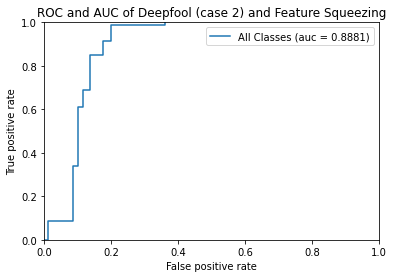

In [ ]:
plt.plot(fpr, tpr, label='All Classes (auc = 0.8881)')
plt.title('ROC and AUC of Deepfool (case 2) and Feature Squeezing')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

In [8]:
"""
Test detection on I-FGSM case 2
"""
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --ifgsm=true

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.58911663
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  11
false positive ratio:  0.1375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  12
detection ratio:  0.15


In [9]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=true --bit=5 --median_smoothing=true --size=3 --lr=0.7 --ifgsm=true

color_depth:  True
reduce to:  5  bits
median_smoothing:  True
filter size:  3 x 3
########## bit depth ##########
### learning threshold c ###
threshold:  1.2370150089263916
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  55
false positive ratio:  0.6875
###
total number of attacked images:  80
total number of detected adversarial samples:  54
detection ratio:  0.675
########## median smoothing ##########
### learning threshold m ###
threshold:  0.8874599
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  9
false positive ratio:  0.1125
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  9
detection ratio:  0.1125


In [10]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=false --size=2 --lr=0.7 --joint=true --ifgsm=true

color_depth:  False
median_smoothing:  False
########## joint detection ##########
### learning threshold c ###
threshold:  1.2370150089263916
### learning threshold m ###
threshold:  0.58911663
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  11
false positive ratio:  0.1375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  12
detection ratio:  0.15


In [1]:
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.0 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.05 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.15 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.20 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.25 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.30 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.40 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.50 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.60 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.70 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.80 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.90 --ifgsm=true
print('#~#~#~#')
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=1.00 --ifgsm=true

#~#~#~#
color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  1.8621094
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  1
false positive ratio:  0.0125
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  0
detection ratio:  0.0
#~#~#~#
color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  1.0541065
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  7
false positive ratio:  0.0875
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  8
detection ratio:  0.1
#~#~#~#
color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###


In [2]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.10 --ifgsm=true

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.58911663
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  11
false positive ratio:  0.1375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  12
detection ratio:  0.15


In [4]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.27 --ifgsm=true

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.023339298
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  20
false positive ratio:  0.25
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  24
detection ratio:  0.3


In [6]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.29 --ifgsm=true

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  0.0091415085
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  24
false positive ratio:  0.3
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  29
detection ratio:  0.3625


In [5]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.65 --ifgsm=true

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  6.890697e-05
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  51
false positive ratio:  0.6375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  57
detection ratio:  0.7125


In [3]:
!python "/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/featuresqueezing.py" \
    --color_depth=false --bit=5 --median_smoothing=true --size=2 --lr=0.7 --fpr=0.95 --ifgsm=true

color_depth:  False
median_smoothing:  True
filter size:  2 x 2
########## median smoothing ##########
### learning threshold m ###
threshold:  4.5055026e-07
### testing threshold ###
###
total number of unttacked images:  80
total number of detected adversarial samples:  75
false positive ratio:  0.9375
###
total number of attacked attacked images:  80
total number of detected adversarial samples:  80
detection ratio:  1.0


In [8]:
import numpy as np
import matplotlib.pyplot as plt
fpr = [0.0000, 0.0125, 0.0875, 0.0875, 0.1375, 0.1375, 0.1750, 0.1750, 0.2000, 0.2000, 0.2250, 0.2250, 0.2500, 0.2500, 0.3000, 0.3000, 0.3625, 0.3625, 0.4250, 0.4250, 0.4500, 0.4500, 0.5625, 0.5625, 0.6375, 0.6375, 0.7250, 0.7250, 0.8000, 0.8000, 0.8625, 0.8625, 0.9375, 0.9375, 1.0000]
tpr = [0.0000, 0.0000, 0.0000, 0.1000, 0.1000, 0.1500, 0.1500, 0.1875, 0.1875, 0.2375, 0.2375, 0.2625, 0.2625, 0.3000, 0.3000, 0.3625, 0.3625, 0.4250, 0.4250, 0.6125, 0.6125, 0.6500, 0.6500, 0.6875, 0.6875, 0.7125, 0.7125, 0.8000, 0.8000, 0.9000, 0.9000, 0.9875, 0.9875, 1.0000, 1.0000]
print(1 - np.trapz(fpr, tpr))

0.5471874999999999


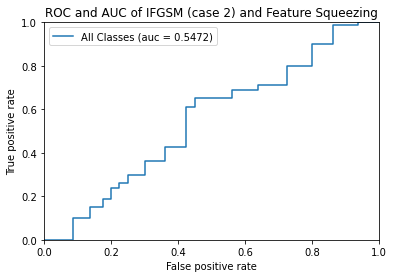

In [9]:
plt.plot(fpr, tpr, label='All Classes (auc = 0.5472)')
plt.title('ROC and AUC of IFGSM (case 2) and Feature Squeezing')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

### Analysis

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

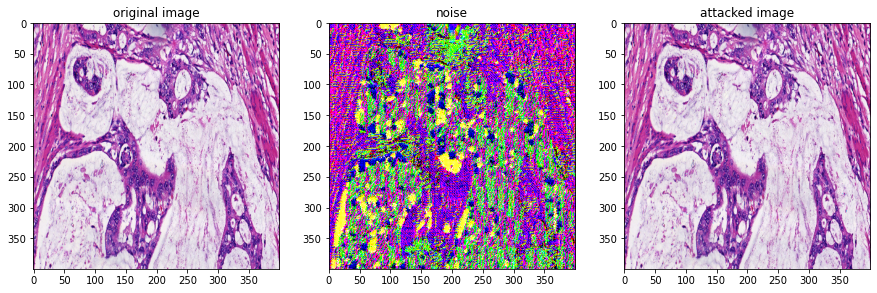

In [ ]:
image_o = Image.open('/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/ori_0.png')
image_r = Image.open('/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/r_0.png')
image_p = Image.open('/content/gdrive/MyDrive/EQ2445/Pytorch_Classification_Intergration/my_data/Master project data/pert_image/pert_0.png')
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
a1 = f.add_subplot(1,3,1)
a1.title.set_text("original image")
a1.imshow(image_o)
a2 = f.add_subplot(1,3,2)
a2.title.set_text("noise")
a2.imshow(image_r)
a3 = f.add_subplot(1,3,3)
a3.title.set_text("attacked image")
a3.imshow(image_p)